# Data Reconciliation in ODYM - Part 2: Monte Carlo Markov Chains

The data reconciliation method presented here deals with arbitrary propbability distribution dunctions describing the uncertainty of observations, hence allowing to discard the assumption of normality distributions.

The Maximum Likelihood Estimetion used in **Data Reconciliation-Part 1** only uses the mean and the variance of the known distributions, and does not take into account the full information contained in an arbitrary pdf. Consequently, the solution no longer can be obtained in closed form, but has to be computed iteratively by suitable algorithms for the constrained minimization. The method implements the Independence Sampler alghoritm described *Cencic et Fruwirth* in https://doi.org/10.1080/02664763.2017.1421916: a Bayesian approach that samples, by a Markov chain Monte Carlo (MCMC) method, from a (**posterior**) distribution  of the reconciled variables under the arbitrary (**prior**) distributions of the observations, under the constraints imposed by the system. 

The method is applied to the same system described in Part 1.
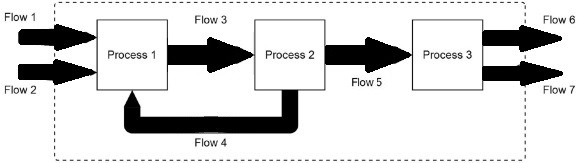

This method assumes that potentially involved unobservable variables have already been eliminated from the system of equations. In Part 1, it has been shown already that Flow6 anf Flow7 cannot be determined unless an additional parameter is considered.

The system has $n=9$ variables: $7$ flows and $2$ parameters. The variables are split into $n_x=6$ **observed** variables, from  measurements or informed judgment on the distribution, and $n_y=3$ unknowns/**unobserved** variables ($y$). 

The system is subject to a system of $n_c=5$ constraints: $3$ mass-balance equations and $2$ model equations (how flows and parameters are linked):

$$Flow_1+Flow_2+Flow_4=Flow_3$$
$$Flow_3=Flow_4+Flow_5$$
$$Flow_5=Flow_6+Flow_7$$
$$Flow_4=Flow_3\cdot TC_{34}$$
$$Flow_7=Flow_6\cdot TC_{67}$$

To solve the system, the number of unknowns cannot be larger than the number of constraints: 
$$n_y \leq n_c \leq n.$$

Given that $n_y = n-n_x$, the inquality on the left is equivalent to
$$n\leq n_x+n_c,$$
meaning that there is enough observed values to clarify the system and estimate the unobserved values. In this case, $3=n_y <= n_c=5$ and the condition is satisfied.

With $n$ variables subject to $n_c$ constraints, $n-n_c$ sets the degree of freedom of the problem, meaning that only a number $n_w=n-n_c$ can be chosen as **free** observed variables ($w$) among the $n_x$ observed variables, leaving the remaining $n_u=n_x-n_w$ as **dependent** observed variables ($u$).

In other words: the $n_c$ constraints can be uniquely solved for a set of $n_c$ dependent variables (observed or unobserved),  that are functions of $n−n_c$ free variables (observed only). Having set $n_w=n-n_c$, the number $n_u$ of observed variables that is set as dependent variable is  
$$n_u=n_x-n_w =(n-n_y)-(n-n_c)=n_c-n_y.$$

In this case:
- $n=9$ variables
- $n_x=6$ observed variables
- $n_y=3$ unobserved variables
- $n_c=5$ constraints
- $n_w=n-n_c=4$ free observed variables
- $n_u=n_c-n_y=2$ dependent observed variables

## 1) System definition

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(),'ODYM', 'odym', 'modules'))
import ODYM_Classes as msc
import ODYM_DataReconciliation as msr

Set-up steps of the system have been explained in **Data Reconciliation-Part 1** and follow the same notation.

In [3]:
DR_System = msc.MFAsystem(Name=None, Geogr_Scope=None, Unit=None, 
                          Time_Start=None,Time_End=None, IndexTable = None, Elements=None)

In [4]:
DR_System.ProcessList = [
    #msc.Process(Name='Environment', ID=0),  #optional
    msc.Process(Name='Process 1', ID=1),
    msc.Process(Name='Process 2', ID=2),
    msc.Process(Name='Process 3', ID=3)    
    ] 

**ID=0** is reserved for the environment outside of the system boundaries. Including the environment in the list of processes is optional, and no process inside the system boundaries can have ID=0.

Unlike the analytical case, flows and parameters do **not** required values and uncertainty to be initiated, which will be  eventually added later as prior distributions.

In [5]:
DR_System.FlowDict['m01_1'] = msc.Flow(Name='Flow 1', P_Start=0, P_End=1, Values=None, Uncert=None)
DR_System.FlowDict['m01_2'] = msc.Flow(Name='Flow 2', P_Start=0, P_End=1, Values=None, Uncert=None)    
DR_System.FlowDict['m12']   = msc.Flow(Name='Flow 3', P_Start=1, P_End=2, Values=None, Uncert=None)
DR_System.FlowDict['m21']   = msc.Flow(Name='Flow 4', P_Start=2, P_End=1, Values=None, Uncert=None)
DR_System.FlowDict['m23']   = msc.Flow(Name='Flow 5', P_Start=2, P_End=3, Values=None, Uncert=None)
DR_System.FlowDict['m30_1'] = msc.Flow(Name='Flow 6', P_Start=3, P_End=0, Values=None, Uncert=None)
DR_System.FlowDict['m30_2'] = msc.Flow(Name='Flow 7', P_Start=3, P_End=0, Values=None, Uncert=None)

Eventually, **stock changes** could also be considered. 
For example, a stock change in process 2 would be described in the FlowDict using *None* as P_Start and 2 as P_end.

In [6]:
DR_System.ParameterDict['TC_34'] = msc.Parameter(Name='TransferCoefficient 3_4', Values=None, Uncert=None)
DR_System.ParameterDict['TC_67'] = msc.Parameter(Name='TransferCoefficient 6_7', Values=None, Uncert=None)

In [7]:
ParametersEquationsList = [
    'm21-m12*TC_34=0',
    'm30_1-m30_2*TC_67=0'
    ] 

## 2) Free observed variables and their prior distributions

The prior distribution of the $n_w=4$ free observed variables has to be assigned in a proper dictionary.

In *Cencic et Fruwirth*, it is shown that the joint posterior distribution of all variables, derived from the posterior distribution of the free variables, is invariant under the choice of the free variables. However, the choice is not arbitrary. The set of free variables is such that an analytical solution for the set of dependent variables and unobserved variables can be found. 
This issue has been discussed already in section 3 of **Data Reconciliation-Part 1**.

For example, m01_1, m12, TC_34, m23 are initally proposed as set of free observed variables. The function *check_system_solution* can be used to check if choice is consistent.

In [8]:
FreeObservedVariablesList = ['m01_1','m12','TC_34','m23']         
DependentObservedVariablesList = ['m01_2','TC_67']
UnobservedVariablesList = ['m21','m30_1','m30_2'] 

print(msr.check_system_solution(DR_System,ParametersEquationsList,UnobservedVariablesList,DependentObservedVariablesList ))

Not a good choice for the free observed variables. Cannot solve the system.


The function returs a warning message if the choice of the free variables would prevent successful data reconciliation. In this case, a different set has to be tried.

In [9]:
FreeObservedVariablesList = ['m01_1','m12','TC_34','TC_67']         
DependentObservedVariablesList = ['m01_2','m23']
UnobservedVariablesList = ['m21','m30_1','m30_2']                   

print(msr.check_system_solution(DR_System,ParametersEquationsList,UnobservedVariablesList,DependentObservedVariablesList ))

The system can be solved with this set of variables!


In [10]:
PriorPDFDict = {
    'm01_1': {
        'name':'truncnorm',
        'parameters':{
            'min': 50,
            'max':150,
            'mean': 100,
            'sd': 10},  
        },
    'm12': {
        'name':'uniform',
        'parameters':{
            'min': 200,
            'max': 400},
        },
    'TC_34': {
        'name':'normal',
        'parameters': {
            'mean': 0.5,
            'sd': 0.05},   
        },
    'TC_67': {
        'name':'triang',
        'parameters': {
            'min':0.5,
            'max': 2,
            'c': 1}
        }
}

The ODYM_DataReconciliation library explicitly implements probability density functions: normal, truncated normal, uniform and triangular. However,  any arbitrary distribution from scipy.stats could be used. In this case, the arguments should be passed with the parametrisation consisten with scipy documentation (https://docs.scipy.org/doc/scipy/reference/stats.html).

For example, a beta distribution given the mean and the standard deviation is parametrised in scipy with parameters *a*,*b*,*loc* and *scale*.

In [11]:
#mean = ..
#sd   = ..
# 'TC_67': {
    #     'name':'beta',
    #     'parameters':{
    #         'a':((1-mean)/sd**2-1/mean))*mean**2',
    #         'b':((1-mean)/sd**2-1/mean))*mean**2 *(1/mean-1),
    #         'loc': 0,
    #         'scale': 1}
    #     }

## 3) Data reconciliation and plots

In [12]:
free, dependent, unobserved = msr.MCMCDataReconciliation(
    MFASystem = DR_System,
    ParametersEquationsList = ParametersEquationsList, 
    UnobservedVariablesList = UnobservedVariablesList,
    FreeObservedVariablesList = FreeObservedVariablesList,
    DependentObservedVariablesList = DependentObservedVariablesList, 
    PriorPDFDict = PriorPDFDict, 
    L = 10000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:43<00:00, 96.94it/s]


The library has a simple plotting function that can be used to plot the results, using a KDE method to smooth the empirical distributions.

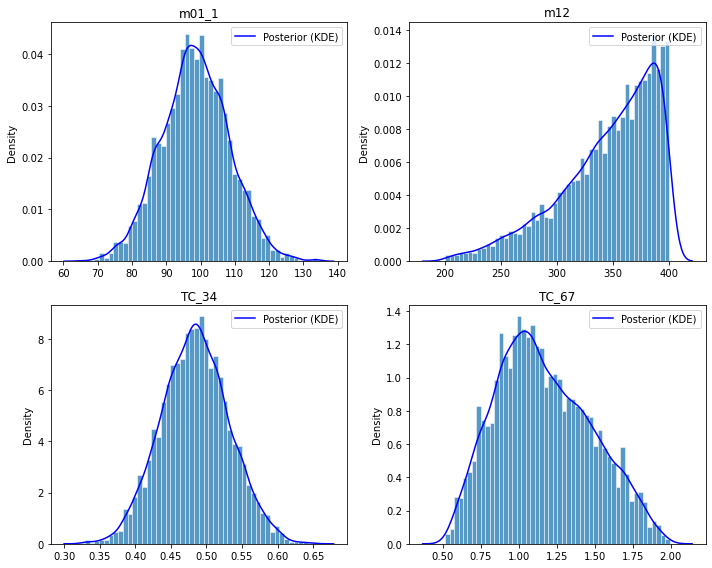

In [17]:
# Plotting the free variables

fig, axs = plt.subplots(2,2,figsize=(10,8))
msr.plot_density(free[:,0] , bins=50, title=FreeObservedVariablesList[0],ax=axs[0,0])
msr.plot_density(free[:,1] , bins=50, title=FreeObservedVariablesList[1], ax=axs[0,1])
msr.plot_density(free[:,2] , bins=50, title=FreeObservedVariablesList[2],ax=axs[1,0])
msr.plot_density(free[:,3] , bins=50, title=FreeObservedVariablesList[3],ax=axs[1,1])
plt.tight_layout()
plt.show()

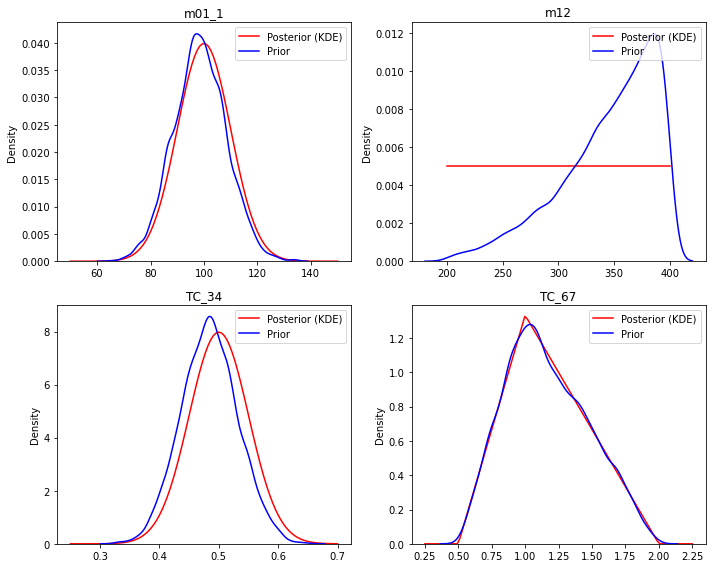

In [18]:
# Plotting the free variables, compared to their prior distribution

fig, axs = plt.subplots(2,2,figsize=(10,8))

axs[0,0].plot(np.linspace(50,150,100),sts.truncnorm.pdf(np.linspace(50,150,100),a=(50-100)/10,b=(150-100)/10, loc=100,scale=10), color='red', label='Prior' )
msr.plot_density(free[:,0] , bins=50, title=FreeObservedVariablesList[0], ax=axs[0,0], density_only=True, prior=True)

axs[0,1].plot(np.linspace(200,400,100),sts.uniform.pdf(np.linspace(200,400,100),loc=200, scale=400-200), color='red', label='Prior' )
msr.plot_density(free[:,1] , bins=50, title=FreeObservedVariablesList[1], ax=axs[0,1], density_only=True, prior=True)

axs[1,0].plot(np.linspace(0.25,0.7,100),sts.norm.pdf(np.linspace(0.25,0.7,100),loc=0.5, scale=0.05), color='red', label='Prior' )
msr.plot_density(free[:,2] , bins=50, title=FreeObservedVariablesList[2],ax=axs[1,0], density_only=True, prior=True)

axs[1,1].plot(np.linspace(0.25,2.25,100),sts.triang.pdf(np.linspace(0.25,2.25,100),c=(1-0.5)/(2-0.5),loc=0.5,scale=2-0.5), color='red', label='Prior' )
msr.plot_density(free[:,3] , bins=50, title=FreeObservedVariablesList[3],ax=axs[1,1], density_only=True, prior=True)

plt.tight_layout()
plt.show()

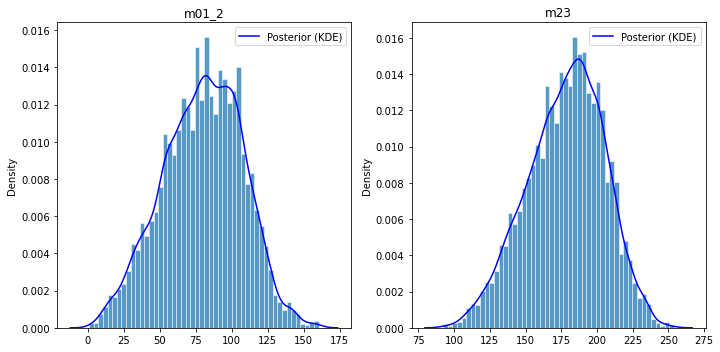

In [19]:
# Plotting the dependent observed variables

fig, axs = plt.subplots(1,2,figsize=(10,5))
msr.plot_density(dependent[:,0] , bins=50, title=DependentObservedVariablesList[0], ax=axs[0])
msr.plot_density(dependent[:,1] , bins=50, title=DependentObservedVariablesList[1], ax=axs[1])
plt.tight_layout()
plt.show()

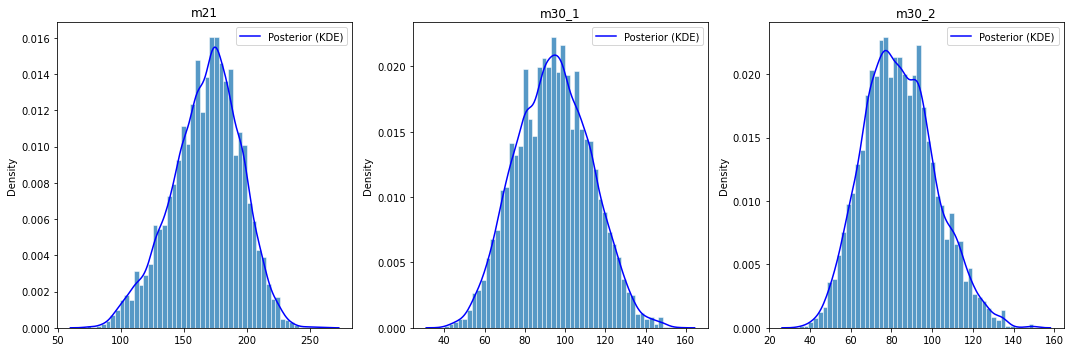

In [20]:
# Plotting the unobserved variables

fig, axs = plt.subplots(1,3,figsize=(15,5))
msr.plot_density(unobserved[:,0] , bins=50, title=UnobservedVariablesList[0], ax=axs[0])
msr.plot_density(unobserved[:,1] , bins=50, title=UnobservedVariablesList[1], ax=axs[1])
msr.plot_density(unobserved[:,2] , bins=50, title=UnobservedVariablesList[2], ax=axs[2])
plt.tight_layout()
plt.show()

## 3) Multi-layer systems 

The DataReconciliation library allows to perform data reconciliation even in the case in which it is not possible to directly express the all the variables as unique flows or parameters. In *Cencic&Fruwirth*, the following example is considered:
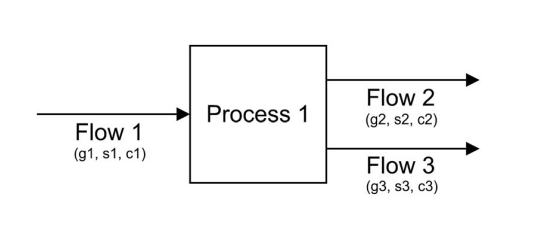
$g_i$ are transported goods, $s_i$ the mass of a substance contained in the good, and $c_i=s_i/g_i$ the mass fractions. In the process, the masses of both the goods and the substances are conserved in the process
$$g_1=g_2+g_3, \;\;\;\; s_1=s_2+s_3, \;\;\;\; s_1=g_1c_1, \;\;\;\; s_2=g_2c_2, \;\;\;\; s_3=g_3c_3.$$

For the same process, two different mass-balance equations hold on different layers of the system. The set-up used above does not distinguish between layers when arranging the flows to create the mass-balance equations for each proseccess.

Insetad, in MCMCDataReconciliation() the instances MFASystem and ParametersEquationsList can be assigned as empty variables, and the entire list of model equations, including the mass-balance, can be assigned.

Such circumstances usually correspond to highly non-linear systems, resulting in significantly longer computation time.

In [21]:
EquationsList =  [
    'g1-g2-g3=0',   # Mass-balance equations
    's1-s2-s3=0',
    's1-g1*c1=0',
    's2-g2*c2=0',   # Mass fraction equations 
    's3-g3*c3=0'
    ]

In [22]:
UnobservedVariablesList = ['s1','s2','s3']
FreeObservedVariablesList = ['g2','g3','c2','c3']
DependentObservedVariablesList = ['g1','c1']

In *Cencic&Fruwirth*, the priors for the free observed variables have beta distributions. Mean, mode and standard deviation are provided, and have to be converted to $\alpha$ and $\beta$ parameters of the scipy parametrisation. The support of the distributions is not explicit and is inferred from the graphs, leading to slight bias compared to the results reported. 

In [23]:
sd_g2 = 3
scale_g2 = 25
loc_g2 = 0
mean_g2 = 9.28
mean_g2=mean_g2/scale_g2
sd_g2 = sd_g2/scale_g2
a_g2 = ((1 - mean_g2) / sd_g2**2 - 1 / mean_g2) * mean_g2**2
b_g2 = a_g2*(1/mean_g2 -1)

sd_g3 = 2
scale_g3 = 15
loc_g3 = 0
mean_g3 = 5.89
mean_g3=mean_g3/scale_g3
sd_g3 = sd_g3/scale_g3
a_g3 = ((1 - mean_g3) / sd_g3**2 - 1 / mean_g3) * mean_g3**2
b_g3 = a_g3*(1/mean_g3 -1)

sd_c2 = 0.02
scale_c2 = 1
loc_c2 = 0
mean_c2 = 0.2
mean_c2=mean_c2/scale_c2
sd_c2 = sd_c2/scale_c2
a_c2 = ((1 - mean_c2) / sd_c2**2 - 1 / mean_c2) * mean_c2**2
b_c2 = a_c2*(1/mean_c2 -1)

sd_c3 = 0.05
scale_c3 = 1
loc_c3 = 0
mean_c3 = 0.5
mean_c3=mean_c3/scale_c3
sd_c3 = sd_c3/scale_c3
a_c3 = ((1 - mean_c3) / sd_c3**2 - 1 / mean_c3) * mean_c3**2
b_c3 = a_c3*(1/mean_c3 -1)

In [24]:
PriorPDFDict = {
    'g2':{
        'name':'beta',
        'parameters':{
            'a':a_g2 ,
            'b':b_g2,
            'loc':loc_g2,
            'scale':scale_g2
            }
        },
    'g3':{
        'name':'beta',
        'parameters':{
            'a':a_g3 ,
            'b':b_g3,
            'loc':loc_g3,
            'scale':scale_g3
            }
        },
    'c2':{
        'name':'beta',
        'parameters':{
            'a':a_c2 ,
            'b':b_c2,
            'loc':loc_c2,
            'scale':scale_c2
            }
        },
    'c3':{
        'name':'beta',
        'parameters':{
            'a':a_c3 ,
            'b':b_c3,
            'loc':loc_c3,
            'scale':scale_c3
            }
        }
    
    }

In [25]:
w,u,y = msr.MCMCDataReconciliation(MFASystem = None,ParametersEquationsList = None,
                                   EquationsList = EquationsList,
                                   UnobservedVariablesList = UnobservedVariablesList, 
                                   FreeObservedVariablesList = FreeObservedVariablesList,
                                   DependentObservedVariablesList = DependentObservedVariablesList, 
                                   PriorPDFDict = PriorPDFDict, 
                                   L = 10000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:52<00:00, 34.19it/s]


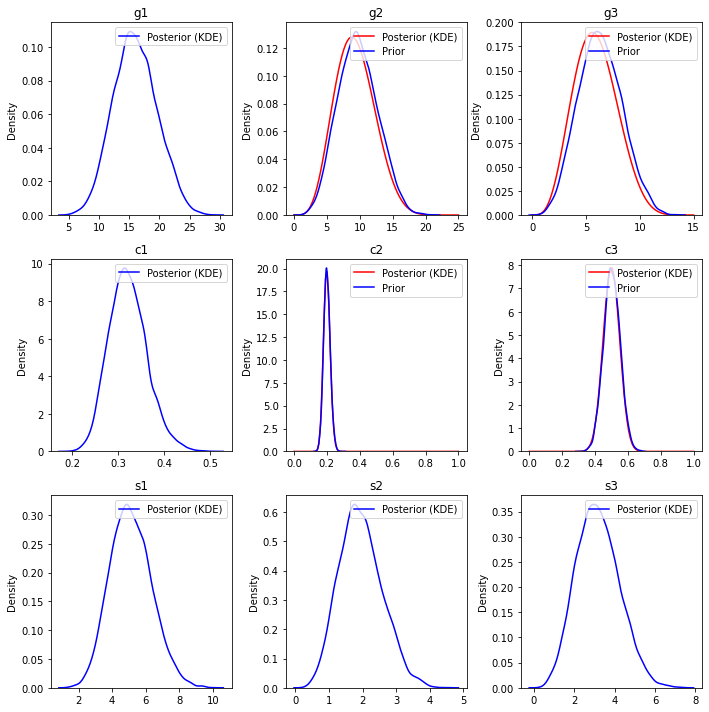

In [28]:
fig, axs = plt.subplots(3,3,figsize=(10,10))

msr.plot_density(u[:,0] , bins=50, title='g1', ax=axs[0,0],density_only= True,prior=False)

axs[0,1].plot(np.linspace(0,PriorPDFDict['g2']['parameters']['scale'],100),
          sts.beta.pdf(np.linspace(0,PriorPDFDict['g2']['parameters']['scale'],100),
          a=PriorPDFDict['g2']['parameters']['a'],
          b=PriorPDFDict['g2']['parameters']['b'], 
          loc=PriorPDFDict['g2']['parameters']['loc'],
          scale=PriorPDFDict['g2']['parameters']['scale']), 
          color='red',
          label='prior')
msr.plot_density(w[:,0] , bins=50, title='g2', ax=axs[0,1],density_only= True,prior=True)

axs[0,2].plot(np.linspace(0,PriorPDFDict['g3']['parameters']['scale'],100),
          sts.beta.pdf(np.linspace(0,PriorPDFDict['g3']['parameters']['scale'],100),
          a=PriorPDFDict['g3']['parameters']['a'],
          b=PriorPDFDict['g3']['parameters']['b'], 
          loc=PriorPDFDict['g3']['parameters']['loc'],
          scale=PriorPDFDict['g3']['parameters']['scale']), 
          color='red',
          label='prior')
msr.plot_density(w[:,1] , bins=50, title='g3', ax=axs[0,2],density_only= True,prior=True)

msr.plot_density(u[:,1] , bins=50, title='c1', ax=axs[1,0],density_only= True,prior=False)

axs[1,1].plot(np.linspace(0,PriorPDFDict['c2']['parameters']['scale'],100),
          sts.beta.pdf(np.linspace(0,PriorPDFDict['c2']['parameters']['scale'],100),
          a=PriorPDFDict['c2']['parameters']['a'],
          b=PriorPDFDict['c2']['parameters']['b'], 
          loc=PriorPDFDict['c2']['parameters']['loc'],
          scale=PriorPDFDict['c2']['parameters']['scale']), 
          color='red',
          label='prior')
msr.plot_density(w[:,2] , bins=50, title='c2', ax=axs[1,1],density_only= True,prior=True)

axs[1,2].plot(np.linspace(0,PriorPDFDict['c3']['parameters']['scale'],100),
          sts.beta.pdf(np.linspace(0,PriorPDFDict['c3']['parameters']['scale'],100),
          a=PriorPDFDict['c3']['parameters']['a'],
          b=PriorPDFDict['c3']['parameters']['b'], 
          loc=PriorPDFDict['c3']['parameters']['loc'],
          scale=PriorPDFDict['c3']['parameters']['scale']), 
          color='red',
          label='prior')
msr.plot_density(w[:,3] , bins=50, title='c3', ax=axs[1,2],density_only= True,prior=True)

msr.plot_density(y[:,0] , bins=50, title='s1', ax=axs[2,0],density_only= True,prior=False)
msr.plot_density(y[:,1] , bins=50, title='s2', ax=axs[2,1],density_only= True,prior=False)
msr.plot_density(y[:,2] , bins=50, title='s3', ax=axs[2,2],density_only= True,prior=False)


plt.tight_layout()
plt.show()